In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns

%matplotlib inline

In [2]:
def display_images(images):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis(False)


(-0.5, 2047.5, 1079.5, -0.5)

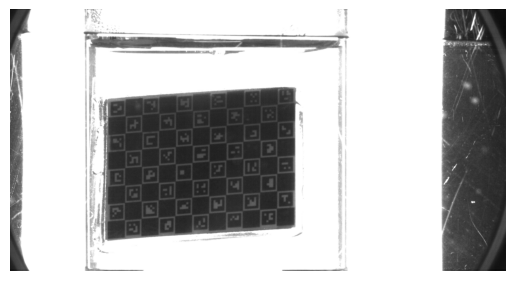

In [3]:
# load images
raw_images = [cv2.imread('../images/cylinder_telecentric/cyl1_exposure30000_360frames_flat/{}.png'.format(i)) for i in range(1, 361)]
plt.imshow(raw_images[0])
plt.axis(False)

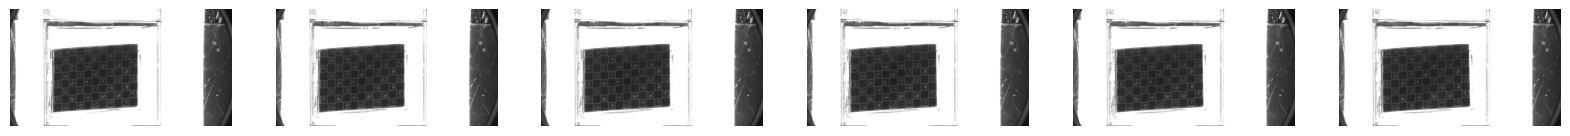

In [4]:
display_images(raw_images[0:6])

360 images in total. Each image with size of (1080, 2048).


(-0.5, 2047.5, 1079.5, -0.5)

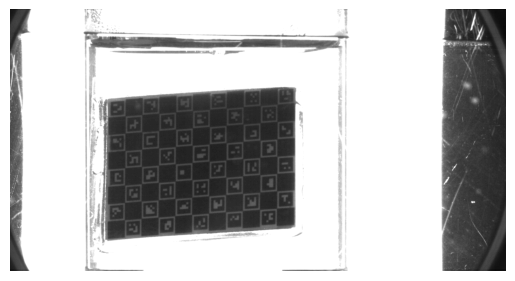

In [5]:
# convert to grayscale
images = [cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY) for raw_image in raw_images]
print(f"{len(images)} images in total. Each image with size of {images[0].shape}.")
plt.imshow(images[0],cmap='gray')
plt.axis(False)

In [6]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
(squaresX, squaresY) = (8, 11)
objp = np.zeros(((squaresX-1) * (squaresY-1), 3), np.float32)
objp[:, :2] = np.mgrid[0:(squaresX-1), 0:(squaresY-1)].T.reshape(-1,2)
objp.shape

(70, 3)

In [8]:
(squareLength, markerLength) = (48/11, 18.75*48/11/24)
print(f'squareLength = {squareLength:.2f} mm')
print(f'markerLength = {markerLength:.2f} mm')

squareLength = 4.36 mm
markerLength = 3.41 mm


In [9]:
# create charuco board
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)
board = cv2.aruco.CharucoBoard((squaresX, squaresY), squareLength, markerLength, aruco_dict)
board

< cv2.aruco.CharucoBoard 00000236C9F9FBF0>

In [10]:
detector = cv2.aruco.CharucoDetector(board)
detector

< cv2.aruco.CharucoDetector 00000236C9F9F470>

In [44]:
# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# save frame index for extrinsic dataset
extrinsics_params = pd.DataFrame()

# loop over all image paths
for i in range(len(images)):
    gray = images[i]
    
    # find aruco markers
    charuco_corners, charuco_ids, _, _ = detector.detectBoard(gray)
    if charuco_corners is not None:
        if len(charuco_corners) == 0:
            continue
    
    if charuco_corners is not None:
        print(f"Image #{i}: detected {len(charuco_corners)} corner(s) among {objp.shape[0]} corners.")

    if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 6 and len(charuco_ids) > 6:
        # store object points and image points
        objp_ = objp[charuco_ids]
        # print(objp_.shape, charuco_corners.shape)
        objpoints.append(objp_)
        imgpoints.append(charuco_corners)

        # add the frame index to the dataset
        data_frame = pd.DataFrame([{'frame':i}])
        extrinsics_params = pd.concat([extrinsics_params,data_frame], ignore_index=True)


Image #0: detected 39 corner(s) among 70 corners.
Image #1: detected 31 corner(s) among 70 corners.
Image #2: detected 42 corner(s) among 70 corners.
Image #3: detected 39 corner(s) among 70 corners.
Image #4: detected 31 corner(s) among 70 corners.
Image #5: detected 33 corner(s) among 70 corners.
Image #6: detected 29 corner(s) among 70 corners.
Image #7: detected 28 corner(s) among 70 corners.
Image #8: detected 23 corner(s) among 70 corners.
Image #9: detected 30 corner(s) among 70 corners.
Image #10: detected 31 corner(s) among 70 corners.
Image #11: detected 25 corner(s) among 70 corners.
Image #12: detected 20 corner(s) among 70 corners.
Image #13: detected 24 corner(s) among 70 corners.
Image #14: detected 24 corner(s) among 70 corners.
Image #15: detected 32 corner(s) among 70 corners.
Image #16: detected 26 corner(s) among 70 corners.
Image #17: detected 21 corner(s) among 70 corners.
Image #18: detected 25 corner(s) among 70 corners.
Image #19: detected 14 corner(s) among 70

In [45]:
print(f"length of extrinsics_params: {len(extrinsics_params)}")
extrinsics_params.head()

length of extrinsics_params: 80


,frame
0,0
1,1
2,2
3,3
4,4


In [12]:
#ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None, flags=(cv2.CALIB_FIX_ASPECT_RATIO + cv2.CALIB_FIX_FOCAL_LENGTH + cv2.CALIB_SAME_FOCAL_LENGTH + cv2.CALIB_ZERO_TANGENT_DIST))
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [13]:
ret,mtx, dist

(0.9625694250218914,
 array([[4.45988874e+04, 0.00000000e+00, 1.03912508e+03],
        [0.00000000e+00, 5.07972303e+04, 5.79393284e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-1.21181970e+01, -8.50262951e+02,  1.15658262e-01,
          6.09639654e-02, -8.85325943e-01]]))

In [43]:
rvecs[0].shape
r1 = [r[0][0] for r in rvecs]
len(r1)
len(extrinsics_params)

95

In [53]:
# save extrinsic parameters
r1 = [r[0][0] for r in rvecs]
r2 = [r[1][0] for r in rvecs]
r3 = [r[2][0] for r in rvecs]
extrinsics_params['r1'] = r1
extrinsics_params['r2'] = r2
extrinsics_params['r3'] = r3

t1 = [t[0][0] for t in tvecs]
t2 = [t[1][0] for t in tvecs]
t3 = [t[2][0] for t in tvecs]
extrinsics_params['t1'] = t1
extrinsics_params['t2'] = t2
extrinsics_params['t3'] = t3
extrinsics_params.to_csv('../parameters/cyl1_exposure30000_360frames_flat.csv',index=False)

Text(0, 0.5, 'error')

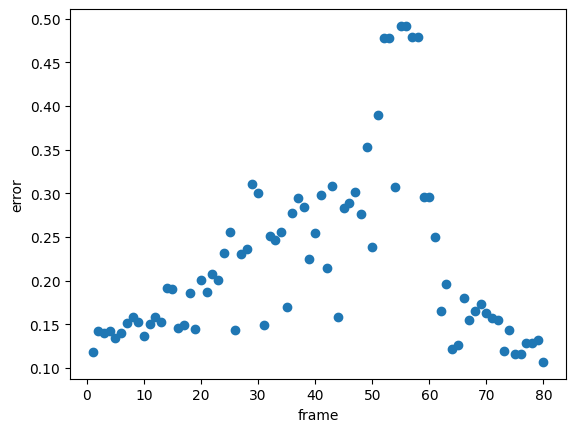

In [41]:
def error_evaluation(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    error_df = pd.DataFrame({'error':[0]})
    for i in range(len(objpoints)):
        # Project object points to image plane
        reprojectedPoints, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        
        img_points = imgpoints
        error = cv2.norm(img_points[i], reprojectedPoints, cv2.NORM_L2) / len(reprojectedPoints)
        new_data = pd.DataFrame({'error':[error]})
        error_df = pd.concat([error_df, new_data], ignore_index=True)
    return error_df
    
error_df = error_evaluation(objpoints, imgpoints,rvecs, tvecs, mtx, dist)[1:]
#error_df
plt.scatter(error_df.index, error_df['error'])
#plt.xlim(0,len(images)+1)
#plt.ylim(0,np.max(error_df['error']))
plt.xlabel('frame')
plt.ylabel('error')

In [42]:
# save camera intrinsic parameters
intrinsics_path = "../parameters/cyl1_exposure30000_360frames_flat.json"
img_width, img_height = images[0].shape[1], images[0].shape[0]
transforms = {
    "fl_x": mtx[0, 0],
    "fl_y": mtx[1, 1],
    "cx": mtx[0, 2],
    "cy": mtx[1, 2],
    "w": img_width,
    "h": img_height,
    "camera_model": "OPENCV",
    "k1": dist[0, 0],
    "k2": dist[0, 1],
    "p1": dist[0, 2],
    "p2": dist[0, 3],
    "k3": dist[0, 4],
}

with open(intrinsics_path, "w") as f:
    json.dump(transforms, f, indent=4)

# displaying the computed extrinsics

In [20]:
# import intrinsic params
intrinsics_path = "../parameters/cyl1_exposure30000_360frames_flat.json"
with open(intrinsics_path, 'r') as json_file:
    intrinsics = json.load(json_file)


In [21]:
# impor mtx and dist
mtx = np.zeros([3,3])
mtx[0,0],mtx[1,1] = intrinsics['fl_x'], intrinsics['fl_y']
mtx[0,2],mtx[1,2] = intrinsics['cx'], intrinsics['cy']
mtx[2,2] = 1

dist = np.array([[intrinsics['k1'], intrinsics['k2'], intrinsics['p1'], intrinsics['p2'], intrinsics['k3']]])


In [73]:
# import extrinsic parameters
extrinsic_path = "../parameters/cyl1_exposure30000_360frames_flat.csv"
extrinsic_params = pd.read_csv(extrinsic_path)
extrinsic_params

,frame,r1,r2,r3,t1,t2,t3
0,0,0.507764,0.255371,-1.561173,-8.002489,3.597211,629.390792
1,1,-0.496937,-0.288388,-1.566702,-7.925708,3.574687,625.822397
2,2,0.497655,0.289469,-1.565701,-7.865164,3.567043,623.863521
3,3,0.495761,0.303081,-1.566670,-7.799187,3.550515,620.894666
4,4,0.494740,0.320807,-1.566604,-7.745727,3.529022,618.818822
...,...,...,...,...,...,...,...
75,355,-0.527254,-0.153772,-1.554733,-8.355232,3.702798,646.791064
76,356,0.528337,0.155772,-1.552813,-8.308626,3.693172,645.022114
77,357,0.525041,0.178099,-1.554128,-8.261701,3.671527,641.960968
78,358,-0.508815,-0.205195,-1.560739,-8.198871,3.655357,638.523298


In [72]:
extrinsic_params.describe()

,frame,r1,r2,r3,t1,t2,t3
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,142.000000,-0.093943,0.040774,-1.578932,-7.239359,3.634159,635.959040
std,154.713864,0.471702,0.396361,0.056004,1.290620,0.165874,27.568819
min,0.000000,-0.729984,-0.642352,-1.668131,-8.749884,3.420381,599.610604
25%,19.750000,-0.532732,-0.351161,-1.618991,-8.533574,3.471634,608.169027
50%,44.500000,-0.138511,0.151770,-1.578333,-7.367739,3.631371,637.100631
75%,339.250000,0.427239,0.396665,-1.541297,-6.295264,3.782360,660.896588
max,359.000000,0.733975,0.632853,-1.475209,-4.637377,3.891841,677.673730


In [80]:
def viz_3d(x,y,z,color):
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=color, marker='o')  # 'c' specifies the color, 'marker' is the marker style
    ax.set_xlabel('X Label - r1')
    ax.set_ylabel('Y Label - r2')
    ax.set_zlabel('Z Label - r3')
    for x, y, z, frame in zip(x, y, z, color):
        ax.text(x-0.05, y, z, str(frame), fontsize=6, color='black', ha='right')
    cbar = plt.colorbar(scatter)
    plt.show()

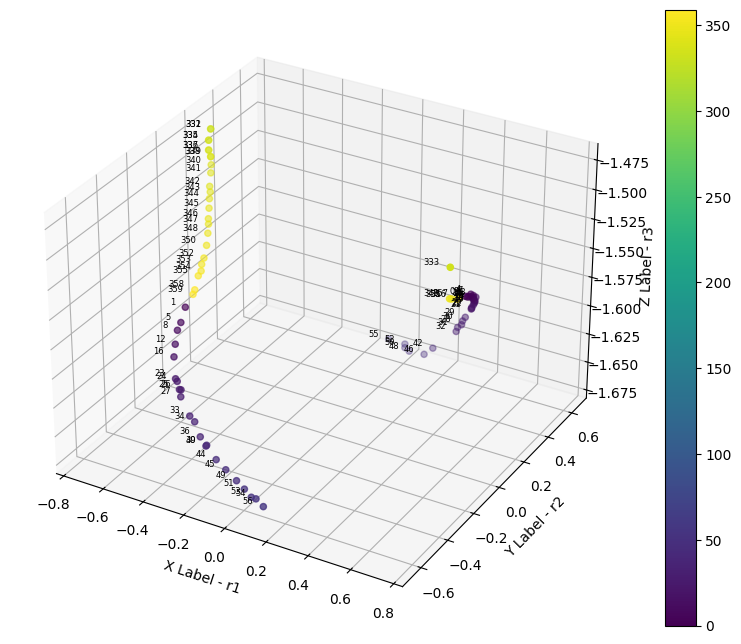

In [81]:
# viz rotation matrix
# The rvec of a marker is a 3D rotation vector which defines both an axis of rotation and the rotation angle about that axis, 
# and gives the marker's orientation.
x = extrinsic_params['r1']
y = extrinsic_params['r2']
z = extrinsic_params['r3']
color = extrinsic_params['frame']

viz_3d(x,y,z,color)

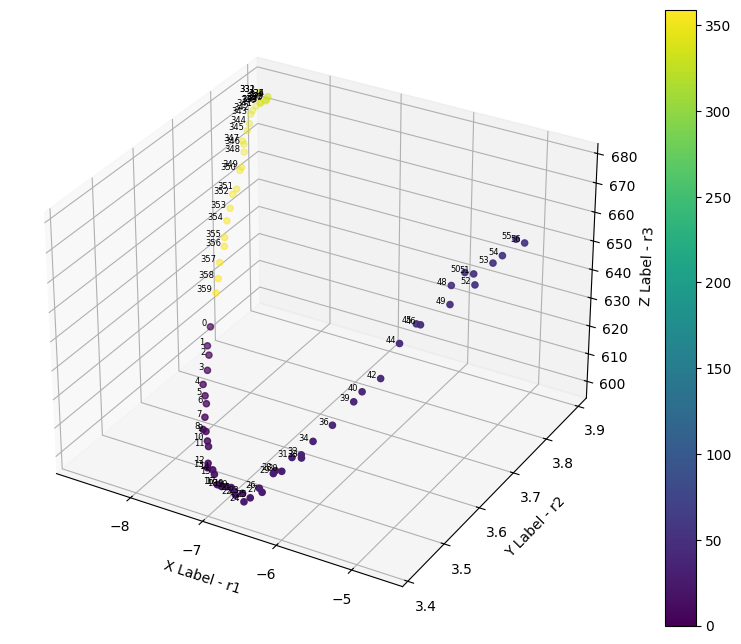

In [82]:
# viz translation matrix
# The tvec of a marker is the translation (x,y,z) of the marker from the origin
x = extrinsic_params['t1']
y = extrinsic_params['t2']
z = extrinsic_params['t3']
color = extrinsic_params['frame']

viz_3d(x,y,z,color)

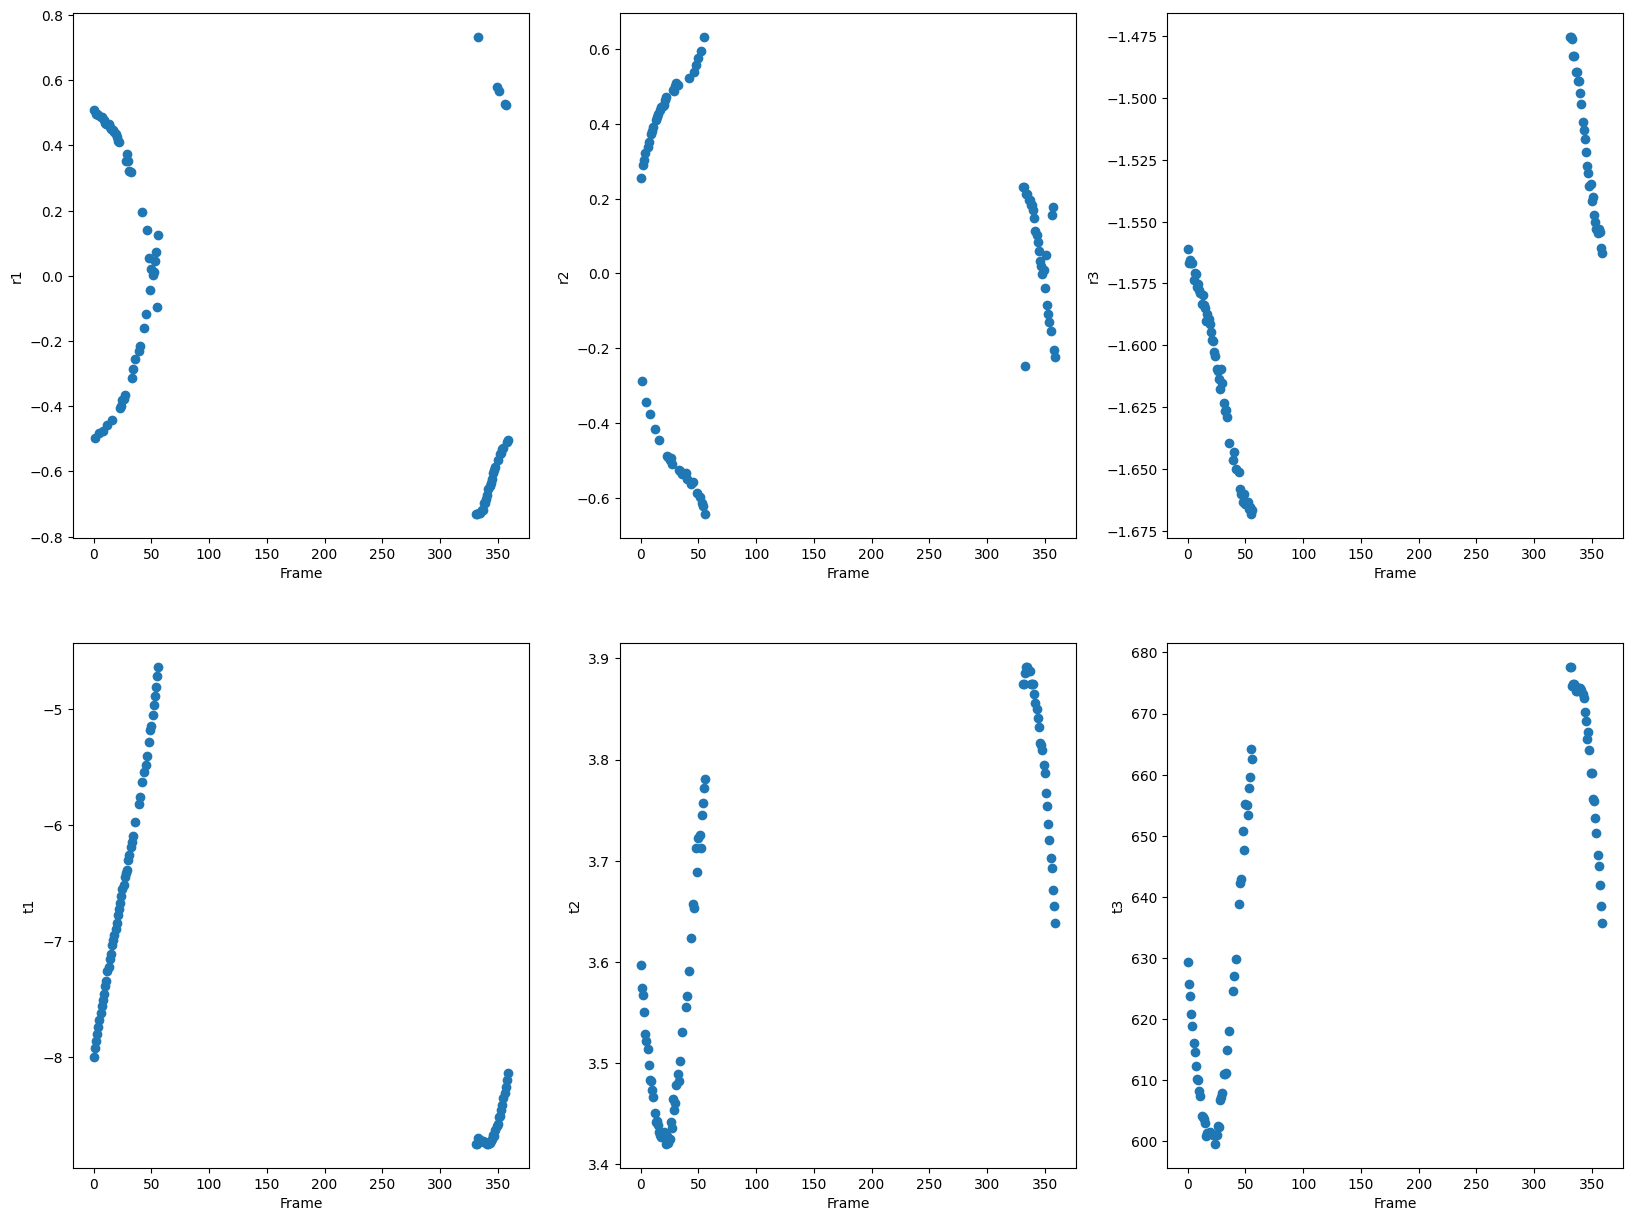

In [99]:
# plot angle with each rvecs/tvecs values
angle = extrinsic_params['frame']
params = [extrinsic_params['r1'],extrinsic_params['r2'],extrinsic_params['r3'],
    extrinsic_params['t1'],extrinsic_params['t2'],extrinsic_params['t3']]
ylabel = ['r1','r2','r3','t1','t2','t3']

plt.figure(figsize=(20,15))
for i in range(len(params)):
    plt.subplot(2, int(len(params)/2), i + 1)
    plt.scatter(angle,params[i])
    plt.xlabel('Frame')
    plt.ylabel(ylabel[i])



In [102]:
extrinsic_params[0:50]

,frame,r1,r2,r3,t1,t2,t3
0,0,0.507764,0.255371,-1.561173,-8.002489,3.597211,629.390792
1,1,-0.496937,-0.288388,-1.566702,-7.925708,3.574687,625.822397
2,2,0.497655,0.289469,-1.565701,-7.865164,3.567043,623.863521
3,3,0.495761,0.303081,-1.566670,-7.799187,3.550515,620.894666
4,4,0.494740,0.320807,-1.566604,-7.745727,3.529022,618.818822
5,5,-0.480796,-0.342906,-1.573422,-7.680758,3.521747,616.180425
6,6,0.487078,0.337565,-1.570633,-7.624331,3.514439,614.681468
7,7,0.488155,0.352306,-1.571160,-7.558297,3.498141,612.347784
8,8,-0.474364,-0.375926,-1.576383,-7.507427,3.483417,610.219515
9,9,0.477589,0.373089,-1.575326,-7.458900,3.482099,610.045664
